In [1]:
import torch.nn as nn
import torch 
import torchaudio 
import json 
import numpy 
from torch.utils.data import DataLoader

'''
# Train_data : 289205
# Valid_data : 12678

pitch = 0~127
velocity = 0~127
instrument_family_str : {bass : 0 , brass : 1, flute : 2, guitar : 3, keyboard : 4 , mallet : 5, organ : 6, reed : 7, string : 8, synth_lead : 9, vocal : 10}
spectrogram : (1, 80, 251)
  sample_rate : 16000
  window_size : 1024
  hop_size : 256
  mel_bins : 80
  fmin : 30
  fmax : 8000
  n_mels : 80


데이터 분석 결과 

velocity : train / valid 데이터의 velocity는 5개만 사용 (25, 50, 75, 100, 127)
pitch : train / valid 데이터의 128개중 112개만 사용
inst : valid엔 synth_lead가 아예 없음. 이유는 예측건데, 다른 악기들에 비해 데이터가 매우 적다 (5501개) 그래서 그러한듯 하다.

'''


class Nsynth():
  def __init__(self, train_mode = True):
    self.pth = '/home/daewoong/userdata/Study/diffusion/nsynth-train-all/'
    
    if train_mode:
      pth = self.pth + 'examples-train-original.json'
      self.data_dict = json.load(open(pth))
    else:
      pth = self.pth + 'examples-valid-original.json'
      self.data_dict = json.load(open(pth))
      
    self.data_dict_keys = list(self.data_dict.keys())
    
    self.inst_dict = {'bass' : 0 , 'brass' : 1, 'flute' : 2, 'guitar' : 3, 'keyboard' : 4 , 'mallet' : 5, 
                      'organ': 6, 'reed' : 7, 'string' : 8, 'synth_lead' : 9, 'vocal' : 10}
    
    self.pitch_dict = {
                        0: 9, 1: 10, 2: 11, 3: 12, 4: 13, 5: 14, 6: 15, 7: 16, 8: 17, 9: 18,
                        10: 19, 11: 20, 12: 21, 13: 22, 14: 23, 15: 24, 16: 25, 17: 26, 18: 27,
                        19: 28, 20: 29, 21: 30, 22: 31, 23: 32, 24: 33, 25: 34, 26: 35, 27: 36,
                        28: 37, 29: 38, 30: 39, 31: 40, 32: 41, 33: 42, 34: 43, 35: 44, 36: 45,
                        37: 46, 38: 47, 39: 48, 40: 49, 41: 50, 42: 51, 43: 52, 44: 53, 45: 54,
                        46: 55, 47: 56, 48: 57, 49: 58, 50: 59, 51: 60, 52: 61, 53: 62, 54: 63,
                        55: 64, 56: 65, 57: 66, 58: 67, 59: 68, 60: 69, 61: 70, 62: 71, 63: 72,
                        64: 73, 65: 74, 66: 75, 67: 76, 68: 77, 69: 78, 70: 79, 71: 80, 72: 81,
                        73: 82, 74: 83, 75: 84, 76: 85, 77: 86, 78: 87, 79: 88, 80: 89, 81: 90,
                        82: 91, 83: 92, 84: 93, 85: 94, 86: 95, 87: 96, 88: 97, 89: 98, 90: 99,
                        91: 100, 92: 101, 93: 102, 94: 103, 95: 104, 96: 105, 97: 106, 98: 107,
                        99: 108, 100: 109, 101: 110, 102: 111, 103: 112, 104: 113, 105: 114,
                        106: 115, 107: 116, 108: 117, 109: 118, 110: 119, 111: 120
                    }
    
    self.velocity_dict = {0 : 25, 1: 50, 2: 75, 3: 100, 4: 127}
    
    self.reverse_pitch_dict = {v: k for k, v in self.pitch_dict.items()}
    self.reverse_velocity_dict = {v: k for k, v in self.velocity_dict.items()}
    
     
  def __len__(self):
    return len(self.data_dict)
  
  def __getitem__(self, idx):
    data_key = self.data_dict_keys[idx]
    spectrogram = self.pth + 'audio/' + data_key + '.wav' + '.spec.npy'
    spectrogram = (torch.from_numpy(numpy.load(spectrogram))).unsqueeze(0)
    instrument = torch.tensor(self.inst_dict[self.data_dict[data_key]['instrument_family_str']])
    pitch = torch.tensor(self.reverse_pitch_dict[int(self.data_dict[data_key]['pitch'])])
    velocity = torch.tensor(self.reverse_velocity_dict[int(self.data_dict[data_key]['velocity'])])
    
    return spectrogram, instrument, pitch, velocity

In [2]:
train_dataset = Nsynth(train_mode=True)
a,b,c,d = train_dataset[0]
a.shape

torch.Size([1, 80, 251])

In [16]:
len(train_dataset.pitch_dict), len(train_dataset.velocity_dict), len(train_dataset.inst_dict)

(112, 5, 11)

In [2]:
from torch.utils.data import DataLoader

train_dataset = Nsynth(train_mode=True)
valid_dataset = Nsynth(train_mode=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
test_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=2)

In [19]:
spectrogram, instrument, pitch, velocity = next(iter(train_dataloader))

In [24]:
k = [instrument, pitch, velocity]
inst_emb = nn.Embedding(11, 256)
inst_emb(k[0])

tensor([[ 1.8728, -1.1397, -0.2659,  ..., -2.3886,  0.8109, -0.8215],
        [-1.0147, -0.1277,  0.1098,  ..., -0.1283,  0.2048,  0.2481],
        [-1.0147, -0.1277,  0.1098,  ..., -0.1283,  0.2048,  0.2481],
        ...,
        [-0.0654, -3.2375, -1.3794,  ..., -1.2806,  0.0386, -0.7628],
        [ 0.4887, -0.1388, -0.5847,  ...,  0.6556, -0.1505, -0.4756],
        [ 1.8728, -1.1397, -0.2659,  ..., -2.3886,  0.8109, -0.8215]],
       grad_fn=<EmbeddingBackward0>)

torch.Size([80, 251])

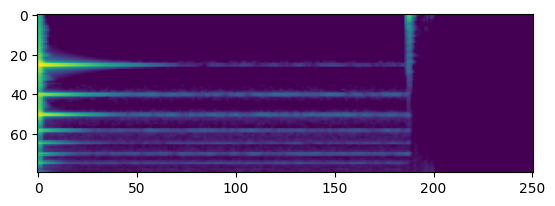

In [285]:
ex_data = train_dataset[0]
spectrogram, instrument, pitch, velocity = ex_data
plt.imshow(spectrogram)
spectrogram.shape

In [294]:
spectrogram.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 80, 251])

torch.Size([1])


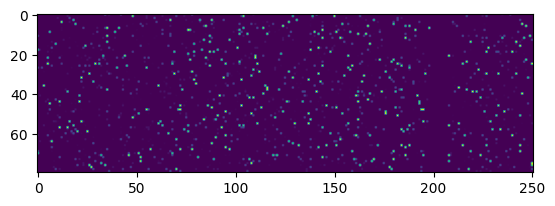

In [345]:
from diffusion_process import Diffusion
diffusion = Diffusion()
t = torch.tensor([0])
print(t.shape)
noise_img, eps = diffusion.noise_images(x=spectrogram.unsqueeze(0).unsqueeze(0).to('cuda'), t=t)
plt.imshow(noise_img.squeeze(0).squeeze(0).cpu().numpy())

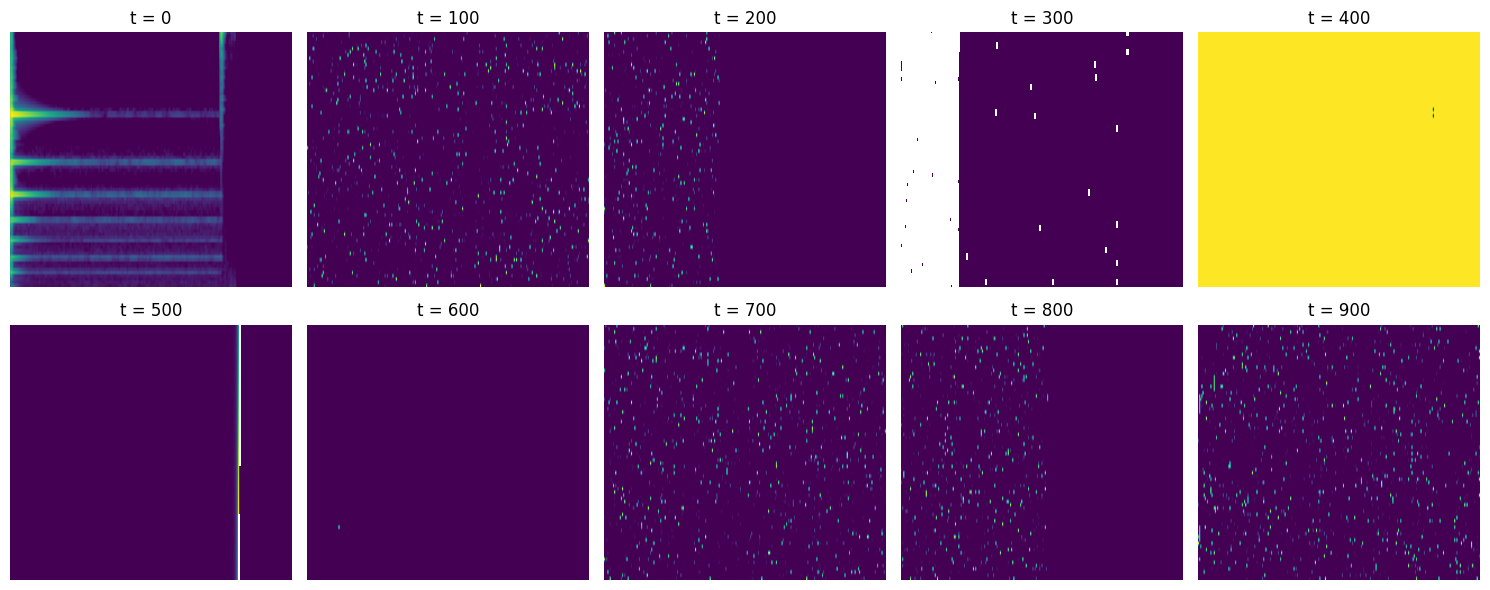

In [354]:
images = []
images.append(spectrogram)
for i in range(0, 1100, 100):
  t = torch.tensor([i])

  noise_img, eps = diffusion.noise_images(x=spectrogram.unsqueeze(0).unsqueeze(0).to('cuda'), t=t)
  images.append(noise_img.squeeze(0).squeeze(0).cpu())

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i], aspect = 'auto')
    ax.set_title(f't = {i*100}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [375]:
from module import Down, Up, SelfAttention, DoubleConv
test_data = spectrogram.unsqueeze(0).unsqueeze(0)
a = DoubleConv(in_c = 1, out_c = 64)
a_out = a(test_data)

b = Down(in_c=64, out_c=128)

  
def pos_encoding(t, channels):
  inv_freq = 1.0 / (
      10000
      ** (torch.arange(0, channels, 2).float() / channels)
  )
  pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
  pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
  pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
  return pos_enc

t = torch.tensor([10])
t = t.unsqueeze(-1).type(torch.float)
t = pos_encoding(t, 256)
    
a_out.shape
b_out = b(x=a_out, t=t)
b_out.shape

torch.Size([1, 128, 40, 125])

In [3]:
class SelfAttention(nn.Module):
  def __init__(self, channels, mel_size, time_size):
    super().__init__()

    self.channels = channels
    self.mel_size = mel_size
    self.time_size = time_size
    self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
    self.ln = nn.LayerNorm(channels)
    self.ff = nn.Sequential(
      nn.LayerNorm(channels),
      nn.Linear(channels, channels),
      nn.GELU(),
      nn.Linear(channels, channels)
    )
    
  def forward(self, x):
    x = x.view(-1, self.channels, self.mel_size*self.time_size).swapaxes(1, 2) # (B x H*W x C)
    x_ln = self.ln(x)
    attention_value, _ = self.mha(x_ln, x_ln, x_ln)
    attention_value = attention_value + x
    attention_value = self.ff(attention_value) + attention_value
    return attention_value.swapaxes(2,1).view(-1, self.channels, self.mel_size, self.time_size)
  
  
sa = SelfAttention(channels=128, mel_size = 40, time_size = 125)

sa1_out = sa(b_out)

NameError: name 'b_out' is not defined

In [6]:
from module import Down, Up, SelfAttention, DoubleConv

class Unet(nn.Module):
  def __init__(self, c_in = 1, c_out = 1, time_dim=256, num_labels = [11, 5, 112]):
    super().__init__()
    self.device = 'cuda'
    self.time_dim = time_dim
    
    self.inst_label_num = num_labels[0]
    self.velocity_label_num = num_labels[1]
    self.pitch_label_num = num_labels[2]
    
    self.mel_size = 80
    self.time_size = 251
    
    self.inc = DoubleConv(c_in, 64)
    self.down1 = Down(64, 128)
    self.sa1 = SelfAttention(128, mel_size = self.mel_size // 2, time_size = self.time_size // 2 )
    self.down2 = Down(128, 256)
    self.sa2 = SelfAttention(256, mel_size = self.mel_size // 4, time_size = self.time_size // 4 )
    self.down3 = Down(256, 256)
    self.sa3 = SelfAttention(256, mel_size = self.mel_size // 8, time_size = self.time_size // 8 )
    
    self.bot1 = DoubleConv(256, 512)
    self.bot2 = DoubleConv(512, 512)
    self.bot3 = DoubleConv(512, 256)
    
    self.up1 = Up(512, 128)
    self.sa4 = SelfAttention(128, mel_size = self.mel_size // 4, time_size = self.time_size // 4)
    self.up2 = Up(in_c = 256, out_c = 64, odd = (40, 125))
    self.sa5 = SelfAttention(64, mel_size = self.mel_size // 2, time_size = self.time_size // 2)
    self.up3 = Up(128, 64, odd = (80, 251))
    self.sa6 = SelfAttention(64, mel_size = self.mel_size, time_size = self.time_size)
    self.outc = nn.Conv2d(64, c_out, kernel_size=1)
    
    if num_labels is not None:
      self.inst_emb = nn.Embedding(self.inst_label_num, time_dim)
      self.velocity_emb = nn.Embedding(self.velocity_label_num, time_dim)
      self.pitch_emb = nn.Embedding(self.pitch_label_num, time_dim)
    
  def pos_encoding(self, t, channels):
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc
    
  def forward(self, x, t, y = None):
    t = t.unsqueeze(-1).type(torch.float)
    t = self.pos_encoding(t, self.time_dim) # [batch, time_dim]
    
    if y is not None:
      t += self.inst_emb(y[0])
      t += self.pitch_emb(y[1])
      t += self.velocity_emb(y[2])

    x1 = self.inc(x) # [batch, 64, 80, 251]
    
    x2 = self.down1(x1, t) # [1, 128, 40, 125]
    x2 = self.sa1(x2) # [batch, 128, 40, 125]
    
    x3 = self.down2(x2, t) #batch, 256, 20, 62]
    x3 = self.sa2(x3)
    
    x4 = self.down3(x3, t)
    x4 = self.sa3(x4)   # [batch, 256, 10, 31]
    
    x4 = self.bot1(x4) # [batch, 512, 10, 31]
    x4 = self.bot2(x4) # [batch, 512, 10, 31])
    x4 = self.bot3(x4) #torch.Size([1, 256, 10, 31])
    
    x = self.up1(x4, x3, t) # [batch, 128, 20, 62]
    x = self.sa4(x) #[batch, 128, 20, 62]
    x = self.up2(x, x2, t)  #([batch, 256, 40, 125])
    x = self.sa5(x)
    x = self.up3(x, x1, t)  #([batch, 64, 80, 251])
    x = self.sa6(x)
    output = self.outc(x)  #([batch, 1, 80, 251])
    
    return output

In [7]:
ex_data = train_dataset[0]
spectrogram, instrument, pitch, velocity = ex_data
model = Unet()
test_data = spectrogram.unsqueeze(0)
t = torch.tensor([0])
test_data
model = model.to('cuda')
out = model(x=test_data.to('cuda'), t= t.to('cuda'))


In [18]:
instrument

tensor(3)